In [1]:
import os
import sys
import numpy as np
import h5py
import scipy.io as spio
import nibabel as nib

sub=1
assert sub in [1,2,5,7]

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
stim_order_f = '/home/ilgiz/dev/boldbrain/data/nsddata/experiments/nsd/nsd_expdesign.mat'
stim_order = loadmat(stim_order_f)

/tmp/ipykernel_58492/2267744726.py:14: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):


In [4]:
## Selecting ids for training and test data
sig_train = {}
sig_test = {}
num_trials = 37*750
for idx in range(num_trials):
    ''' nsdId as in design csv files'''
    nsdId = stim_order['subjectim'][sub-1, stim_order['masterordering'][idx] - 1] - 1
    if stim_order['masterordering'][idx]>1000:
        if nsdId not in sig_train:
            sig_train[nsdId] = []
        sig_train[nsdId].append(idx)
    else:
        if nsdId not in sig_test:
            sig_test[nsdId] = []
        sig_test[nsdId].append(idx)


train_im_idx = list(sig_train.keys())
test_im_idx = list(sig_test.keys())

In [7]:
roi_dir = '/home/ilgiz/dev/boldbrain/data/nsddata/ppdata/subj{:02d}/func1pt8mm/roi/'.format(sub)
# betas_dir = 'nsddata_betas/ppdata/subj{:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/'.format(sub)

mask_filename = 'nsdgeneral.nii.gz'
mask = nib.load(roi_dir+mask_filename).get_fdata()
print(mask.shape)

num_voxel = mask[mask>0].shape[0]

# fmri = np.zeros((num_trials, num_voxel)).astype(np.float32)
# for i in range(37):
#     beta_filename = "betas_session{0:02d}.nii.gz".format(i+1)
#     beta_f = nib.load(betas_dir+beta_filename).get_fdata().astype(np.float32)
#     fmri[i*750:(i+1)*750] = beta_f[mask>0].transpose()
#     del beta_f
#     print(i)
    
print("fMRI Data are loaded.")

(81, 104, 83)
fMRI Data are loaded.


In [6]:
imgs_path = '/home/ilgiz/dev/boldbrain/data/imgs/sub{:02d}'.format(sub)
f_stim = h5py.File('/home/ilgiz/dev/boldbrain/data/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
for i,idx in enumerate(train_im_idx):
    np.save(os.path.join(imgs_path, 'train', str(i) + '.npy'), f_stim['imgBrick'][idx])

for i,idx in enumerate(test_im_idx):
    np.save(os.path.join(imgs_path, 'test', str(i) + '.npy'), f_stim['imgBrick'][idx])

KeyboardInterrupt: 

(425, 425, 3)


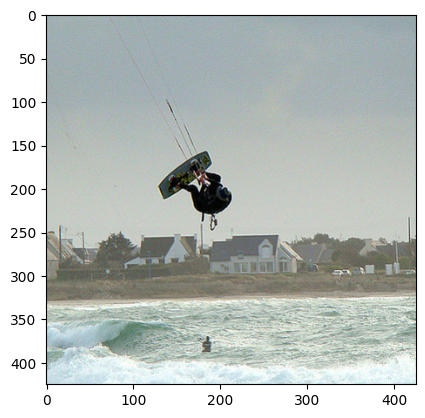

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(f_stim['imgBrick'][0])
print(f_stim['imgBrick'][0].shape)

In [ ]:

# stim = f_stim['imgBrick'][:]

# print("Stimuli are loaded.")

# num_train, num_test = len(train_im_idx), len(test_im_idx)
# vox_dim, im_dim, im_c = num_voxel, 425, 3
# fmri_array = np.zeros((num_train,vox_dim))
# stim_array = np.zeros((num_train,im_dim,im_dim,im_c))
# for i,idx in enumerate(train_im_idx):
#     stim_array[i] = stim[idx]
#     fmri_array[i] = fmri[sorted(sig_train[idx])].mean(0)
#     print(i)

# np.save('processed_data/subj{:02d}/nsd_train_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub),fmri_array )
# np.save('processed_data/subj{:02d}/nsd_train_stim_sub{}.npy'.format(sub,sub),stim_array )

# print("Training data is saved.")

# fmri_array = np.zeros((num_test,vox_dim))
# stim_array = np.zeros((num_test,im_dim,im_dim,im_c))
# for i,idx in enumerate(test_im_idx):
#     stim_array[i] = stim[idx]
#     fmri_array[i] = fmri[sorted(sig_test[idx])].mean(0)
#     print(i)

# np.save('processed_data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub),fmri_array )
# np.save('processed_data/subj{:02d}/nsd_test_stim_sub{}.npy'.format(sub,sub),stim_array )

# print("Test data is saved.")

# annots_cur = np.load('annots/COCO_73k_annots_curated.npy')

# captions_array = np.empty((num_train,5),dtype=annots_cur.dtype)
# for i,idx in enumerate(train_im_idx):
#     captions_array[i,:] = annots_cur[idx,:]
#     print(i)
# np.save('processed_data/subj{:02d}/nsd_train_cap_sub{}.npy'.format(sub,sub),captions_array )
    
# captions_array = np.empty((num_test,5),dtype=annots_cur.dtype)
# for i,idx in enumerate(test_im_idx):
#     captions_array[i,:] = annots_cur[idx,:]
#     print(i)
# np.save('processed_data/subj{:02d}/nsd_test_cap_sub{}.npy'.format(sub,sub),captions_array )

# print("Caption data are saved.")